i will be only use ARIMA model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv('/content/TimeSeries_TotalSolarGen_and_Load_IT_2016.csv')
data.head(5)

,utc_timestamp,IT_load_new,IT_solar_generation
0,2016-01-01T00:00:00Z,21665.0,1
1,2016-01-01T01:00:00Z,20260.0,0
2,2016-01-01T02:00:00Z,19056.0,0
3,2016-01-01T03:00:00Z,18407.0,0
4,2016-01-01T04:00:00Z,18425.0,0


Text(0, 0.5, 'Value')

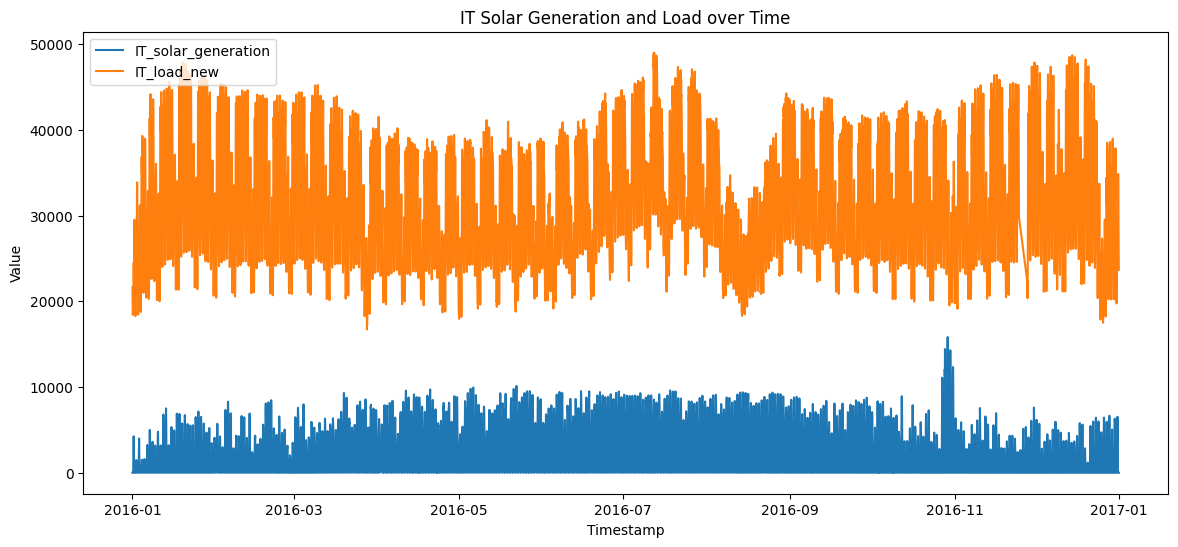

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'])
plt.figure(figsize=(14,6))
sns.lineplot(x='utc_timestamp', y='IT_solar_generation', data=data, label='IT_solar_generation')
sns.lineplot(x='utc_timestamp', y='IT_load_new', data=data, label='IT_load_new')
plt.legend()
plt.title('IT Solar Generation and Load over Time')
plt.xlabel('Timestamp')
plt.ylabel('Value')

Text(0, 0.5, 'Value')

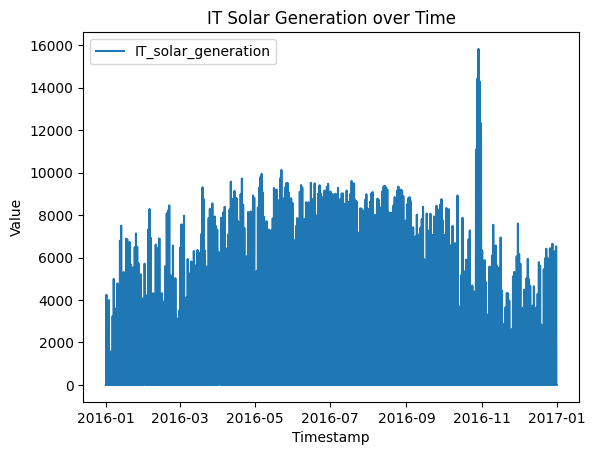

In [9]:
sns.lineplot(x='utc_timestamp', y='IT_solar_generation', data=data, label='IT_solar_generation')
plt.legend()
plt.title('IT Solar Generation over Time')
plt.xlabel('Timestamp')
plt.ylabel('Value')

this show a clear pattern and with generation during the day and no generation at night

In [10]:
#handle missing values
data.isnull().sum()

,0
utc_timestamp,0
IT_load_new,72
IT_solar_generation,0


In [11]:
data['IT_load_new'] = data['IT_load_new'].fillna(method='ffill')
data.isnull().sum()

/tmp/ipython-input-1636481713.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['IT_load_new'] = data['IT_load_new'].fillna(method='ffill')


,0
utc_timestamp,0
IT_load_new,0
IT_solar_generation,0


In [12]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

check_stationarity(data['IT_solar_generation'].dropna())


Results of Dickey-Fuller Test:
Test Statistic                -5.741335e+00
p-value                        6.265438e-07
#Lags Used                     3.600000e+01
Number of Observations Used    8.747000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861870e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


In [ ]:
# PACF plot for IT_load_new
plt.figure(figsize=(12, 6))
plot_pacf(data['IT_load_new'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) for IT_load_new')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

In [13]:
check_stationarity(data['IT_load_new'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -1.197390e+01
p-value                        3.841445e-22
#Lags Used                     3.700000e+01
Number of Observations Used    8.746000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


for both columns, p value is less than 0.05.so statonary

we need to find p,d,q


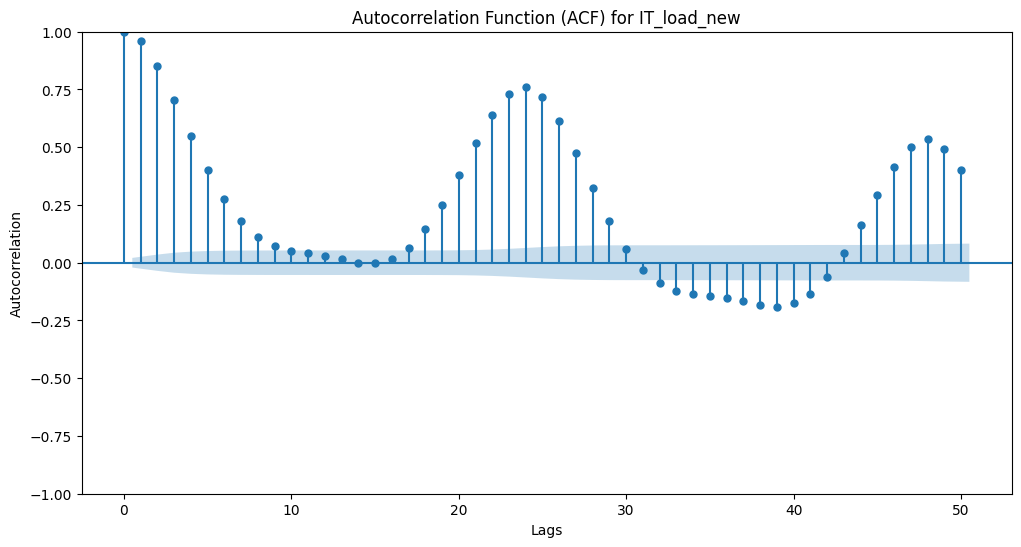

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# ACF plot for IT_load_new
plt.figure(figsize=(12, 6))
plot_acf(data['IT_load_new'], lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) for IT_load_new')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

from acf,pacf plot we see a sharp drop after lag=2 and so p2q2

In [17]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming we are modeling 'IT_solar_generation'
series = data['IT_solar_generation']

# Split data into training and testing sets (e.g., 80% train, 20% test)
train_size = int(len(series) * 0.8)
train, test = series[0:train_size], series[train_size:]

# Define the ARIMA model parameters (p, d, q)
p, d, q = 2, 0, 2

# Fit the ARIMA model
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.predict(start=len(train), end=len(data)-1)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'RMSE for ARIMA({p},{d},{q}): {rmse:.3f}')

RMSE for ARIMA(2,0,2): 2486.151


this has risk


In [24]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Split the data into training and test sets
train_size = int(len(data['IT_load_new']) * 0.8)
train, test = data['IT_load_new'][:train_size], data['IT_load_new'][train_size:]

# Fit the ARIMA model
model = ARIMA(train, order=(2,0,2))
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test, predictions))
rmse

7714.95213482925

In [25]:
model2 = ARIMA(train, order=(2,1,2))
model_fit2 = model2.fit()
predictions2 = model_fit2.predict(start=len(train), end=len(train)+len(test)-1)
rmse2 = sqrt(mean_squared_error(test, predictions2))
rmse2

7993.84942771682

In [26]:
model3 = ARIMA(train, order=(2,2,2))
model_fit3 = model3.fit()
predictions3 = model_fit3.predict(start=len(train), end=len(train)+len(test)-1)
rmse3 = sqrt(mean_squared_error(test, predictions3))
rmse3

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9290.388604796251

So model 2 is less . we take model 2

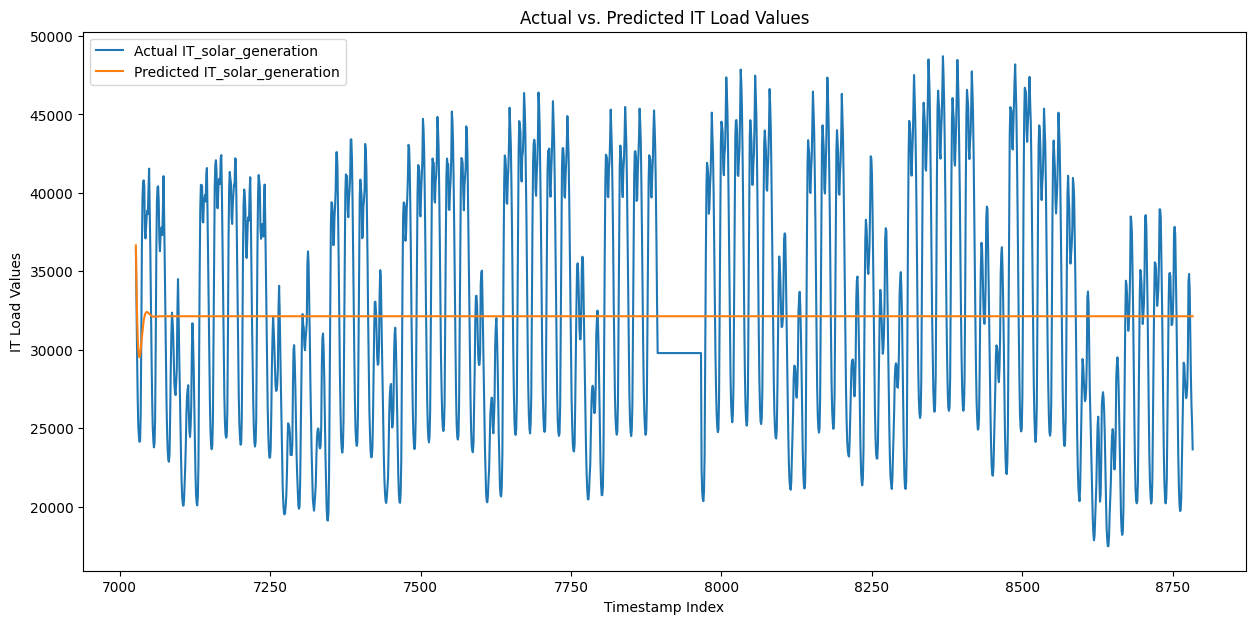

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 7))
sns.lineplot(x=test.index, y=test, label='Actual IT_solar_generation')
sns.lineplot(x=predictions.index, y=predictions, label='Predicted IT_solar_generation')
plt.title('Actual vs. Predicted IT Load Values')
plt.xlabel('Timestamp Index')
plt.ylabel('IT Load Values')
plt.legend()
plt.show()

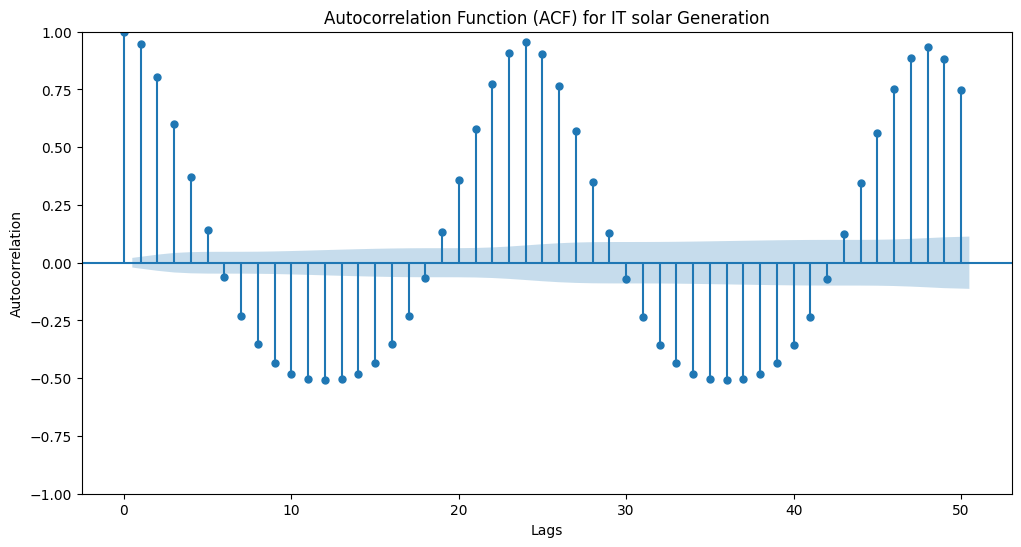

In [29]:
plt.figure(figsize=(12, 6))
plot_acf(data['IT_solar_generation'], lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) for IT solar Generation')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

In [30]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Split the data into training and test sets
train_size = int(len(data['IT_solar_generation']) * 0.8)
train, test = data['IT_solar_generation'][:train_size], data['IT_solar_generation'][train_size:]

# Fit the ARIMA model
model = ARIMA(train, order=(2,0,2))
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test, predictions))
rmse

2486.1507110911857

In [31]:


# Fit the ARIMA model
model4 = ARIMA(train, order=(2,1,2))
model_fit4 = model4.fit()

# Make predictions on the test set
predictions4 = model_fit4.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse4 = sqrt(mean_squared_error(test, predictions4))
rmse4

2364.522593259139

In [33]:


# Fit the ARIMA model
model5 = ARIMA(train, order=(2,2,2))
model_fit5 = model5.fit()

# Make predictions on the test set
predictions5 = model_fit5.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse5 = sqrt(mean_squared_error(test, predictions5))
rmse5

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5461.735671045549

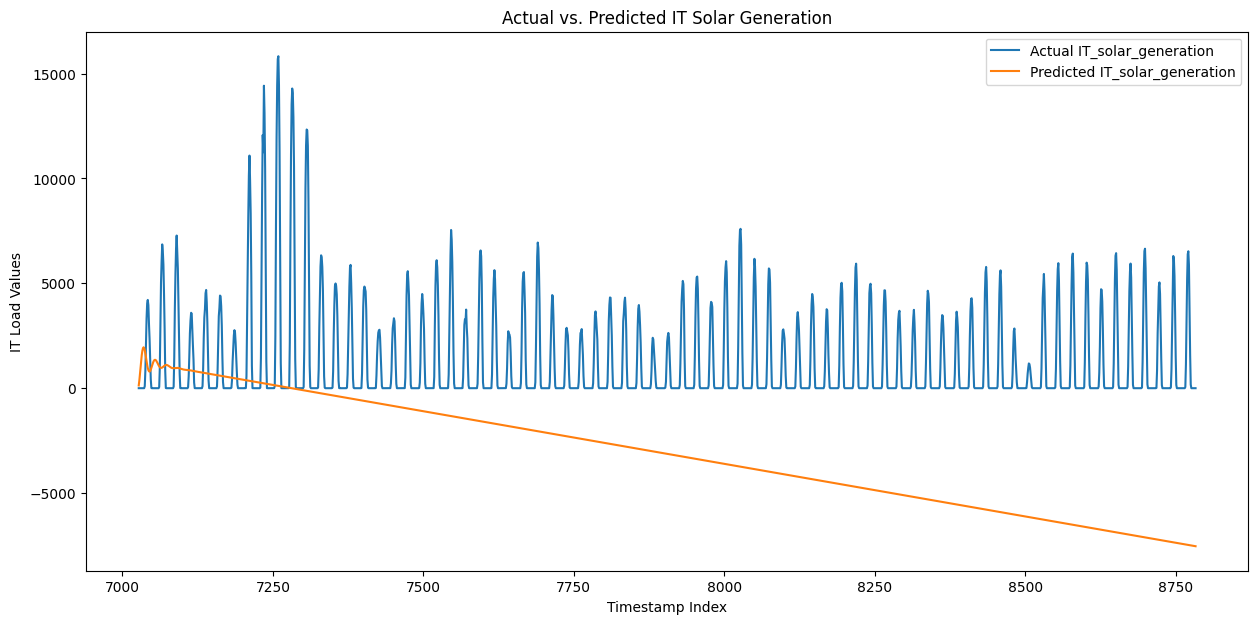

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 7))
sns.lineplot(x=test.index, y=test, label='Actual IT_solar_generation')
sns.lineplot(x=predictions5.index, y=predictions5, label='Predicted IT_solar_generation')
plt.title('Actual vs. Predicted IT Solar Generation')
plt.xlabel('Timestamp Index')
plt.ylabel('IT Load Values')
plt.legend()
plt.show()

this show something wrong

But we know how the process work